In [2]:
import warnings
warnings.filterwarnings("ignore")


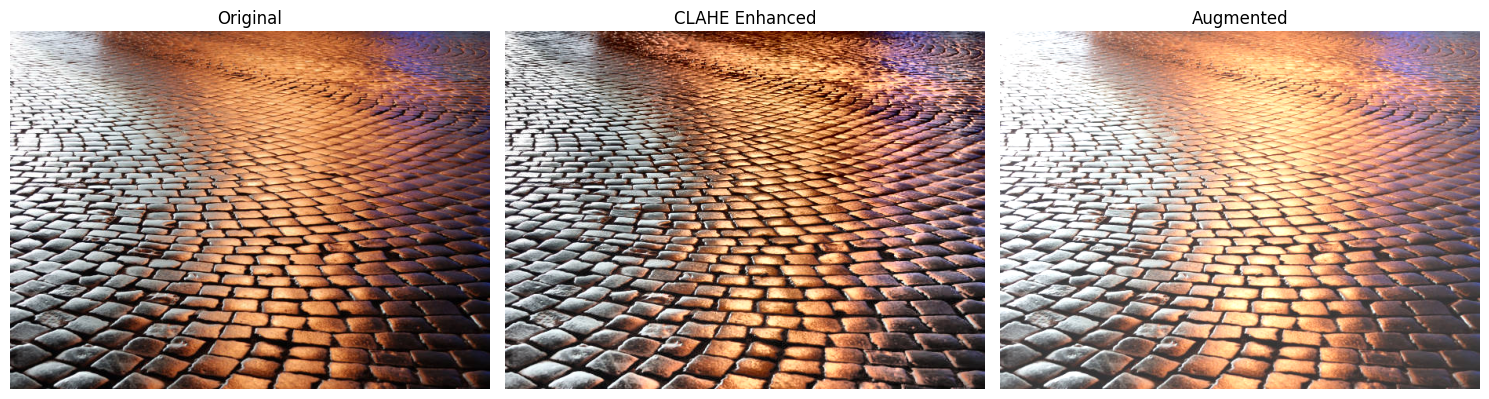

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from albumentations import (
    Compose, RandomBrightnessContrast, HorizontalFlip,
    Blur, GaussNoise, CLAHE
)

# ✅ 1. CLAHE-based low-light enhancement
def enhance_clahe(image):
    # Convert image to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    # Merge the enhanced L-channel with A and B
    limg = cv2.merge((cl, a, b))

    # Convert back to RGB
    enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return enhanced

# ✅ 2. Augmentation pipeline using Albumentations (v2.0.5-compatible)
def get_train_aug():
    return Compose([
        CLAHE(clip_limit=4.0, p=0.5),  # Applied again for variation
        RandomBrightnessContrast(p=0.7),
        HorizontalFlip(p=0.5),
        GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        Blur(blur_limit=3, p=0.3),
    ])

# ✅ 3. Visualization helper
def plot_three(image1, image2, image3, titles=["Original", "CLAHE Enhanced", "Augmented"]):
    plt.figure(figsize=(15, 5))
    for i, img in enumerate([image1, image2, image3]):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ✅ 4. Load one test image
img_path = "/kaggle/input/dataset/not-damaged-20250526T075830Z-1-001/not-damaged/pavement_without_hazard_image_1.jpg"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ✅ 5. Apply CLAHE enhancement
clahe_image = enhance_clahe(image)

# ✅ 6. Apply augmentation
augmentations = get_train_aug()
augmented = augmentations(image=image)['image']

# ✅ 7. Plot original, enhanced, and augmented
plot_three(image, clahe_image, augmented)


## Custoum CNN

Epoch [1/10] Train Loss: 0.5551 | Val Loss: 0.6705 | Val Acc: 0.6867
*** Saved Best Model with Val Acc: 0.6867
Epoch [2/10] Train Loss: 0.4896 | Val Loss: 0.3798 | Val Acc: 0.7831
*** Saved Best Model with Val Acc: 0.7831
Epoch [3/10] Train Loss: 0.4503 | Val Loss: 0.3789 | Val Acc: 0.8193
*** Saved Best Model with Val Acc: 0.8193
Epoch [4/10] Train Loss: 0.4394 | Val Loss: 0.3318 | Val Acc: 0.7952
Epoch [5/10] Train Loss: 0.4363 | Val Loss: 0.3167 | Val Acc: 0.8675
*** Saved Best Model with Val Acc: 0.8675
Epoch [6/10] Train Loss: 0.3955 | Val Loss: 0.3198 | Val Acc: 0.8554
Epoch [7/10] Train Loss: 0.4059 | Val Loss: 0.3717 | Val Acc: 0.8434
Epoch [8/10] Train Loss: 0.3901 | Val Loss: 0.2985 | Val Acc: 0.8916
*** Saved Best Model with Val Acc: 0.8916
Epoch [9/10] Train Loss: 0.3955 | Val Loss: 0.2858 | Val Acc: 0.8916
Epoch [10/10] Train Loss: 0.3898 | Val Loss: 0.3466 | Val Acc: 0.8072


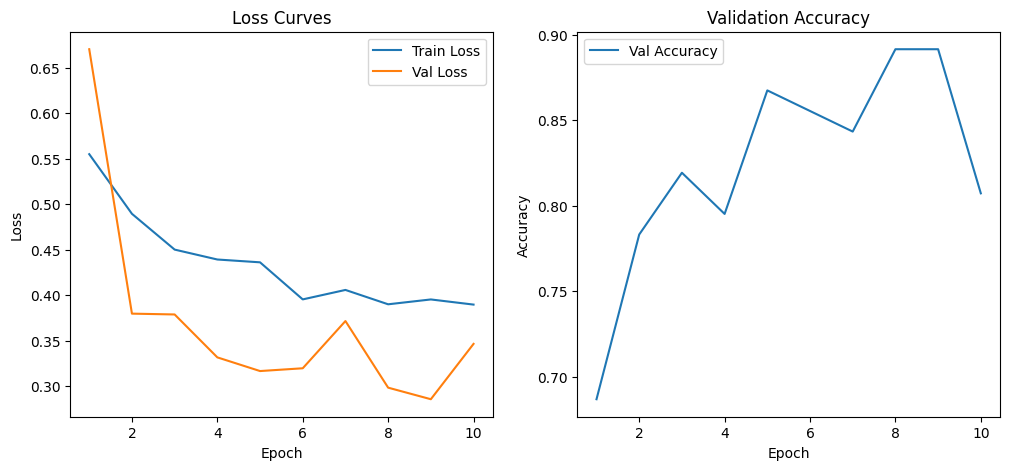

=== Validation Results ===
              precision    recall  f1-score   support

 Not Damaged       0.86      0.92      0.89        39
     Damaged       0.93      0.86      0.89        44

    accuracy                           0.89        83
   macro avg       0.89      0.89      0.89        83
weighted avg       0.89      0.89      0.89        83



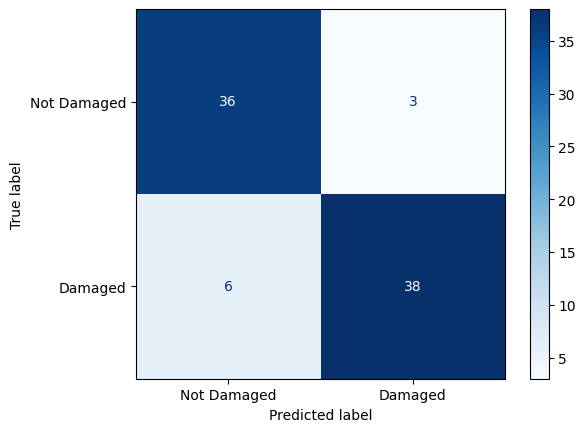

=== Test Results ===
              precision    recall  f1-score   support

 Not Damaged       0.84      0.93      0.88        40
     Damaged       0.92      0.84      0.88        43

    accuracy                           0.88        83
   macro avg       0.88      0.88      0.88        83
weighted avg       0.88      0.88      0.88        83



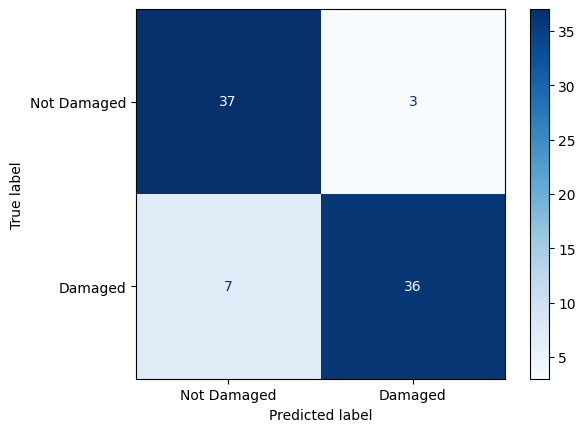

In [4]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
MODEL_SAVE_PATH = "custom_cnn_best.pth"

# ----------- Data Augmentation and Preprocessing -------------

def low_light_enhancement(image):
    gamma = 1.5
    look_up_table = np.array([((i / 255.0) ** (1.0 / gamma)) * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, look_up_table)

def heavy_augmentation():
    def transform(image):
        image = low_light_enhancement(image)

        if random.random() < 0.7:
            alpha = 1.0 + (random.random() * 0.6 - 0.3)
            beta = random.randint(-20, 20)
            image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

        if random.random() < 0.5:
            image = cv2.flip(image, 1)

        if random.random() < 0.5:
            angle = random.uniform(-15, 15)
            M = cv2.getRotationMatrix2D((IMG_SIZE // 2, IMG_SIZE // 2), angle, 1)
            image = cv2.warpAffine(image, M, (IMG_SIZE, IMG_SIZE))

        if random.random() < 0.5:
            scale = random.uniform(0.9, 1.1)
            h, w = image.shape[:2]
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, 0, scale)
            image = cv2.warpAffine(image, M, (w, h))

        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image.astype(np.float32) / 255.0
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = (image - mean) / std
        image = np.transpose(image, (2, 0, 1))

        return torch.tensor(image, dtype=torch.float32)
    return transform

def val_augmentation():
    def transform(image):
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image.astype(np.float32) / 255.0
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = (image - mean) / std
        image = np.transpose(image, (2, 0, 1))
        return torch.tensor(image, dtype=torch.float32)
    return transform

# ---------------- Dataset ----------------
class AugmentedDataset(Dataset):
    def __init__(self, image_paths, labels, augment_times=1, transforms=None):
        self.image_paths = image_paths
        self.labels = labels
        self.augment_times = augment_times
        self.transforms = transforms

        self.expanded_paths = []
        self.expanded_labels = []
        for _ in range(augment_times):
            self.expanded_paths.extend(image_paths)
            self.expanded_labels.extend(labels)

    def __len__(self):
        return len(self.expanded_paths)

    def __getitem__(self, idx):
        img_path = self.expanded_paths[idx]
        label = self.expanded_labels[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transforms:
            image = self.transforms(image)

        return image, torch.tensor(label, dtype=torch.long)

# ---------------- Prepare Dataset ----------------
def prepare_dataset():
    hazardous_dir = "/kaggle/input/dataset/damaged-20250526T075728Z-1-001/damaged"
    nonhazardous_dir = "/kaggle/input/dataset/not-damaged-20250526T075830Z-1-001/not-damaged"

    hazardous_imgs = [os.path.join(hazardous_dir, f) for f in os.listdir(hazardous_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    nonhazardous_imgs = [os.path.join(nonhazardous_dir, f) for f in os.listdir(nonhazardous_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    all_imgs = hazardous_imgs + nonhazardous_imgs
    all_labels = [1]*len(hazardous_imgs) + [0]*len(nonhazardous_imgs)

    # Split into train, val, test (70/15/15)
    train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
        all_imgs, all_labels, test_size=0.3, stratify=all_labels, random_state=42
    )
    val_imgs, test_imgs, val_labels, test_labels = train_test_split(
        temp_imgs, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )
    return train_imgs, val_imgs, test_imgs, train_labels, val_labels, test_labels

# ---------------- Custom CNN Model ----------------
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 224x224x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 112x112x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56x64

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 56x56x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28x128

            nn.Conv2d(128, 256, kernel_size=3, padding=1), # 28x28x256
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14x256

            nn.Conv2d(256, 512, kernel_size=3, padding=1), # 14x14x512
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)  # 1x1x512
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ---------------- Training Function ----------------
def train_model(model, train_loader, val_loader):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0
    history = {"train_loss": [], "val_loss": [], "val_acc": []}

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"*** Saved Best Model with Val Acc: {best_acc:.4f}")

    return history

# ---------------- Plot Training Curves ----------------
def plot_training(history):
    epochs = range(1, NUM_EPOCHS + 1)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curves")

    plt.subplot(1,2,2)
    plt.plot(epochs, history["val_acc"], label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Validation Accuracy")

    plt.show()

# ---------------- Evaluation ----------------
def evaluate_model(model, data_loader, show_cm=True):
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    model.to(DEVICE)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    print(classification_report(all_labels, all_preds, target_names=['Not Damaged', 'Damaged']))

    if show_cm:
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(cm, display_labels=['Not Damaged', 'Damaged'])
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

# ---------------- Main ----------------
def main():
    train_imgs, val_imgs, test_imgs, train_labels, val_labels, test_labels = prepare_dataset()

    train_dataset = AugmentedDataset(train_imgs, train_labels, augment_times=3, transforms=heavy_augmentation())
    val_dataset = AugmentedDataset(val_imgs, val_labels, augment_times=1, transforms=val_augmentation())
    test_dataset = AugmentedDataset(test_imgs, test_labels, augment_times=1, transforms=val_augmentation())

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    model = CustomCNN().to(DEVICE)
    history = train_model(model, train_loader, val_loader)
    plot_training(history)

    print("=== Validation Results ===")
    evaluate_model(model, val_loader, show_cm=True)

    print("=== Test Results ===")
    evaluate_model(model, test_loader, show_cm=True)

if __name__ == "__main__":
    main()


### Resnet full script

Preparing data loaders...
Building ResNet50 model...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


Training model...
Epoch [1/5] Train Loss: 0.3519 Train Acc: 0.8682 | Val Loss: 0.0792 Val Acc: 0.9639
Epoch [2/5] Train Loss: 0.1633 Train Acc: 0.9457 | Val Loss: 0.1572 Val Acc: 0.9398
Epoch [3/5] Train Loss: 0.1098 Train Acc: 0.9690 | Val Loss: 0.1999 Val Acc: 0.9518
Epoch [4/5] Train Loss: 0.1185 Train Acc: 0.9845 | Val Loss: 0.1142 Val Acc: 0.9759
Epoch [5/5] Train Loss: 0.0815 Train Acc: 0.9742 | Val Loss: 0.0585 Val Acc: 0.9759

✅ Model saved as resnet50_hazard_model.pth


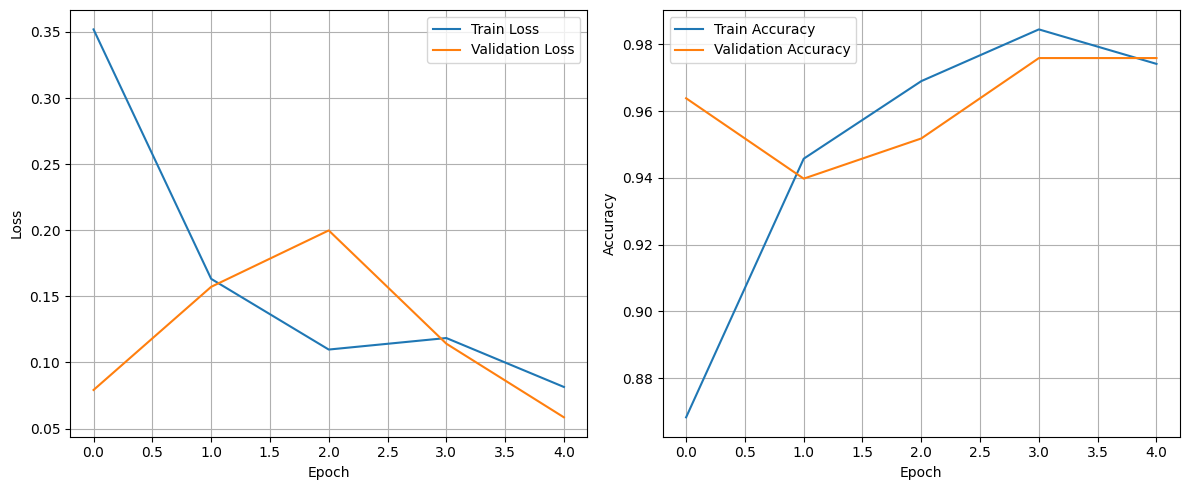

Loading best model and evaluating on test set...

--- Test Set Evaluation Report ---
              precision    recall  f1-score   support

  Not Hazard       0.97      0.93      0.95        40
      Hazard       0.93      0.98      0.95        43

    accuracy                           0.95        83
   macro avg       0.95      0.95      0.95        83
weighted avg       0.95      0.95      0.95        83



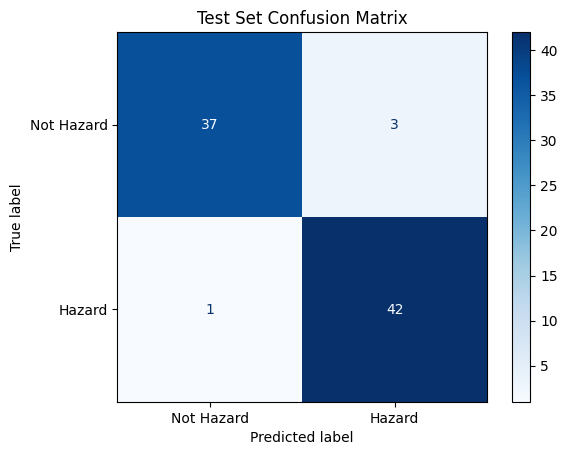

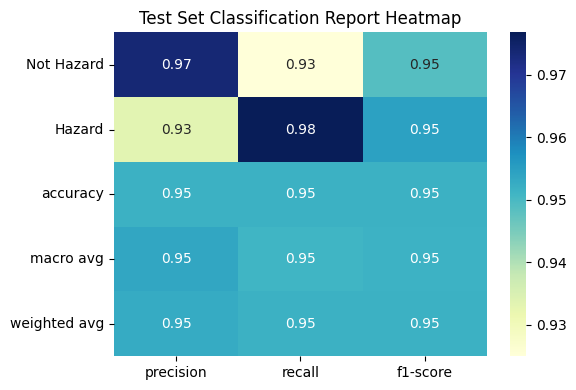

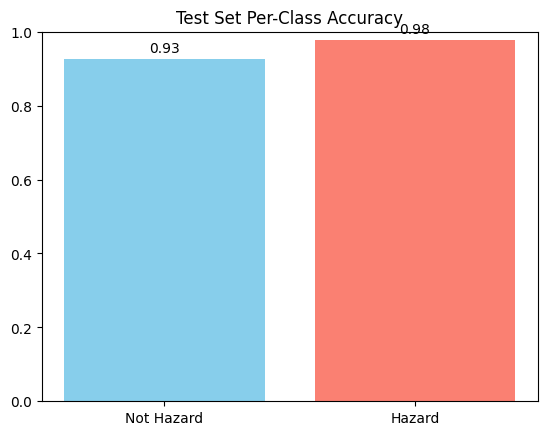

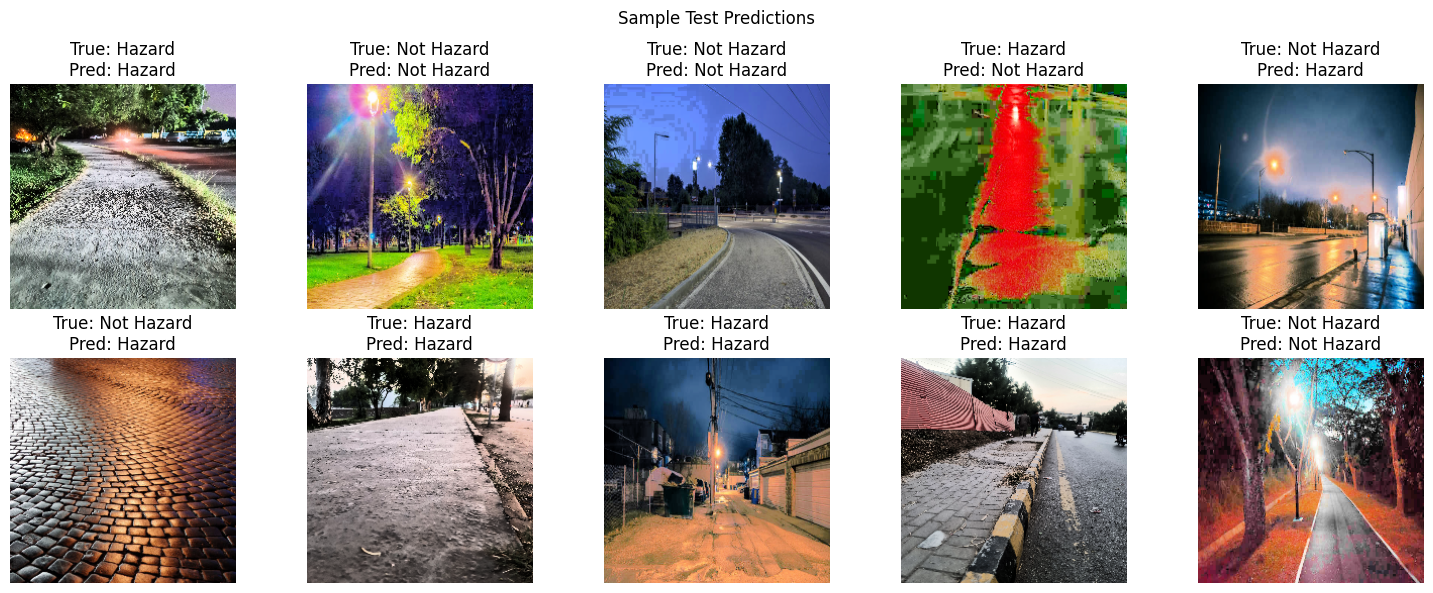

In [5]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim

warnings.filterwarnings("ignore")

# Device and seeds
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Constants
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 5
LEARNING_RATE = 1e-4
CLASS_NAMES = ["Not Hazard", "Hazard"]
MODEL_PATH = "resnet50_hazard_model.pth"

# Low-light enhancement function (using simple histogram equalization on V channel in HSV)
def low_light_enhance(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:, :, 2] = cv2.equalizeHist(hsv[:, :, 2])
    enhanced = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return enhanced

class SidewalkDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, enhance_low_light=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.enhance_low_light = enhance_low_light

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.enhance_low_light:
            image = low_light_enhance(image)
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, torch.tensor(label, dtype=torch.long)

def get_transforms(train=True):
    if train:
        return A.Compose([
            A.RandomBrightnessContrast(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
            A.Resize(IMG_SIZE, IMG_SIZE),
            A.Normalize(),
            ToTensorV2()
        ])
    else:
        # No augmentations for val/test except resize + normalize
        return A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE),
            A.Normalize(),
            ToTensorV2()
        ])

def prepare_data():
    damaged_dir = "/kaggle/input/dataset/damaged-20250526T075728Z-1-001/damaged"
    not_damaged_dir = "/kaggle/input/dataset/not-damaged-20250526T075830Z-1-001/not-damaged"

    damaged_imgs = [os.path.join(damaged_dir, img) for img in os.listdir(damaged_dir)]
    not_damaged_imgs = [os.path.join(not_damaged_dir, img) for img in os.listdir(not_damaged_dir)]

    all_images = damaged_imgs + not_damaged_imgs
    all_labels = [1] * len(damaged_imgs) + [0] * len(not_damaged_imgs)

    # 70% train, 15% val, 15% test stratified split
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_images, all_labels, test_size=0.3, stratify=all_labels, random_state=42)

    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

    train_dataset = SidewalkDataset(train_paths, train_labels, transform=get_transforms(train=True), enhance_low_light=True)
    val_dataset = SidewalkDataset(val_paths, val_labels, transform=get_transforms(train=False), enhance_low_light=True)
    test_dataset = SidewalkDataset(test_paths, test_labels, transform=get_transforms(train=False), enhance_low_light=True)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader

def build_resnet50():
    model = resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model.to(DEVICE)

def train_model(model, train_loader, val_loader):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        val_loss, val_accuracy = evaluate(model, val_loader, criterion)

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Train Loss: {avg_train_loss:.4f} Train Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} Val Acc: {val_accuracy:.4f}")

    torch.save(model.state_dict(), MODEL_PATH)
    print(f"\n✅ Model saved as {MODEL_PATH}")

    # Plot losses and accuracies
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

def evaluate(model, data_loader, criterion=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            if criterion:
                loss = criterion(outputs, labels)
                running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(data_loader) if criterion else 0
    accuracy = correct / total

    return avg_loss, accuracy

def test_model(model, test_loader):
    model.eval()
    y_true, y_pred, all_images = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())
            all_images.extend(images.cpu())

    print("\n--- Test Set Evaluation Report ---")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Test Set Confusion Matrix")
    plt.show()

    report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
    plt.figure(figsize=(6, 4))
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap="YlGnBu")
    plt.title("Test Set Classification Report Heatmap")
    plt.tight_layout()
    plt.show()

    per_class_acc = [cm[i, i] / cm[i].sum() for i in range(len(CLASS_NAMES))]
    plt.bar(CLASS_NAMES, per_class_acc, color=['skyblue', 'salmon'])
    plt.title("Test Set Per-Class Accuracy")
    plt.ylim(0, 1)
    for i, acc in enumerate(per_class_acc):
        plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center')
    plt.show()

    # Sample predictions
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for idx, ax in enumerate(axes.flatten()):
        img = all_images[idx].permute(1, 2, 0).numpy()
        img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # unnormalize
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"True: {CLASS_NAMES[y_true[idx]]}\nPred: {CLASS_NAMES[y_pred[idx]]}")
    plt.suptitle("Sample Test Predictions")
    plt.tight_layout()
    plt.show()

def main():
    print("Preparing data loaders...")
    train_loader, val_loader, test_loader = prepare_data()

    print("Building ResNet50 model...")
    model = build_resnet50()

    print("Training model...")
    train_model(model, train_loader, val_loader)

    print("Loading best model and evaluating on test set...")
    model.load_state_dict(torch.load(MODEL_PATH))
    test_model(model, test_loader)

if __name__ == "__main__":
    main()


## Efficent Net

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


Preparing data...

Building EfficientNetB0 model...


100%|██████████| 20.5M/20.5M [00:00<00:00, 78.2MB/s]



Training model...
Epoch [1/5], Loss: 0.5754, Val Acc: 0.9036
Epoch [2/5], Loss: 0.3164, Val Acc: 0.9157
Epoch [3/5], Loss: 0.2553, Val Acc: 0.9398
Epoch [4/5], Loss: 0.1530, Val Acc: 0.9398
Epoch [5/5], Loss: 0.1078, Val Acc: 0.9518

Evaluating model on test set...

--- Test Set Classification Report ---
              precision    recall  f1-score   support

  Not Hazard       1.00      0.90      0.95        40
      Hazard       0.91      1.00      0.96        43

    accuracy                           0.95        83
   macro avg       0.96      0.95      0.95        83
weighted avg       0.96      0.95      0.95        83



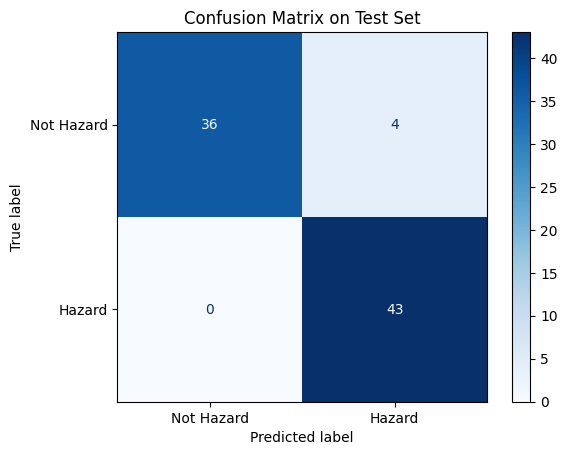

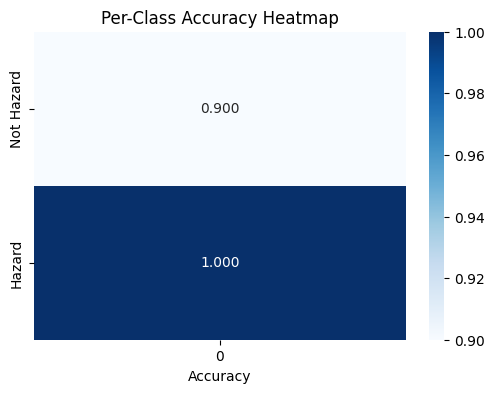

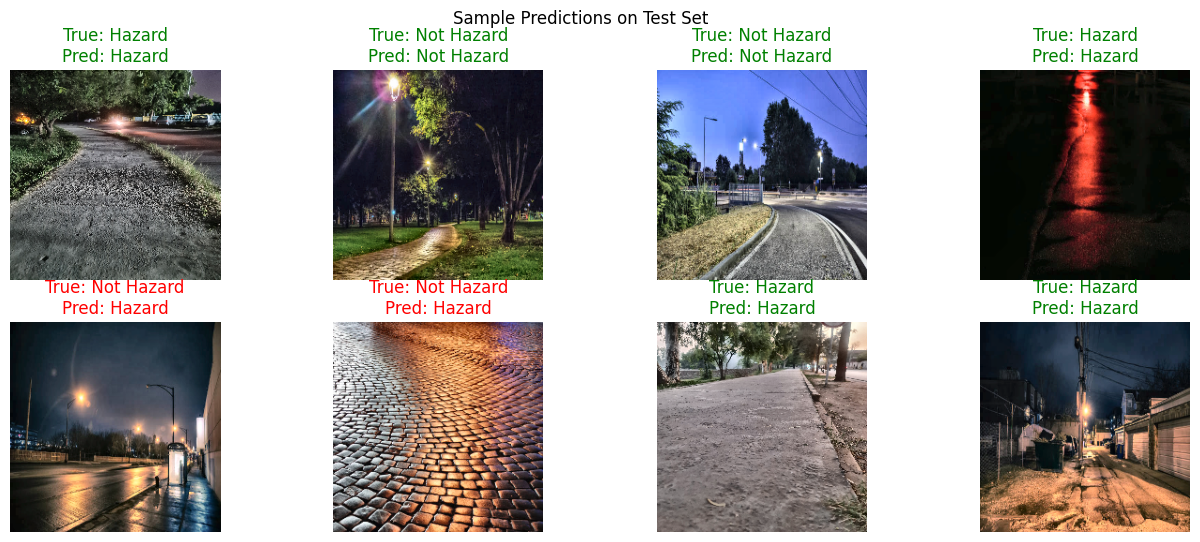

In [6]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0
import torch.nn as nn
import torch.optim as optim

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 5
LEARNING_RATE = 1e-4
CLASS_NAMES = ["Not Hazard", "Hazard"]

# ---------------- Dataset ----------------
class SidewalkDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
            
        return image, torch.tensor(label, dtype=torch.long)

# ---------------- Augmentation ----------------
def get_train_transforms():
    return A.Compose([
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=0.5),   # Histogram equalization (CLAHE)
        A.RandomBrightnessContrast(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(),
        ToTensorV2()
    ])

def get_val_test_transforms():
    return A.Compose([
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=1.0),  # Always apply CLAHE for val/test
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(),
        ToTensorV2()
    ])

# ---------------- Data Preparation ----------------
def prepare_data():
    damaged_dir = "/kaggle/input/dataset/damaged-20250526T075728Z-1-001/damaged"
    not_damaged_dir = "/kaggle/input/dataset/not-damaged-20250526T075830Z-1-001/not-damaged"

    damaged_imgs = [os.path.join(damaged_dir, img) for img in os.listdir(damaged_dir)]
    not_damaged_imgs = [os.path.join(not_damaged_dir, img) for img in os.listdir(not_damaged_dir)]

    all_images = damaged_imgs + not_damaged_imgs
    all_labels = [1] * len(damaged_imgs) + [0] * len(not_damaged_imgs)

    # First split 70% train, 30% temp (val + test)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_images, all_labels, test_size=0.3, stratify=all_labels, random_state=42)
    
    # Then split temp into 15% val and 15% test (of total dataset)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)
    
    train_dataset = SidewalkDataset(train_paths, train_labels, transform=get_train_transforms())
    val_dataset = SidewalkDataset(val_paths, val_labels, transform=get_val_test_transforms())
    test_dataset = SidewalkDataset(test_paths, test_labels, transform=get_val_test_transforms())

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader, test_labels

# ---------------- Model ----------------
def build_efficientnet():
    model = efficientnet_b0(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    return model.to(DEVICE)

# ---------------- Training ----------------
def train_model(model, train_loader, val_loader):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    best_model_wts = None

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        val_acc = validate_model(model, val_loader)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()

    # Load best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    return model

def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# ---------------- Evaluation ----------------
def evaluate_model(model, test_loader, test_labels):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())

    print("\n--- Test Set Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix on Test Set")
    plt.show()

    # Per-class accuracy heatmap
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    plt.figure(figsize=(6,4))
    sns.heatmap(per_class_acc.reshape(-1,1), annot=True, fmt=".3f", yticklabels=CLASS_NAMES, cmap="Blues")
    plt.title("Per-Class Accuracy Heatmap")
    plt.xlabel("Accuracy")
    plt.show()

    # Show sample predictions
    show_sample_predictions(model, test_loader)

def show_sample_predictions(model, test_loader, num_samples=8):
    model.eval()
    images_list = []
    labels_list = []
    preds_list = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            images_list.extend(images.cpu())
            labels_list.extend(labels)
            preds_list.extend(preds.cpu())

            if len(images_list) >= num_samples:
                break

    plt.figure(figsize=(16,6))
    for i in range(num_samples):
        img = images_list[i].permute(1,2,0).numpy()
        # Unnormalize
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        true_label = CLASS_NAMES[labels_list[i]]
        pred_label = CLASS_NAMES[preds_list[i]]
        color = "green" if true_label == pred_label else "red"

        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis("off")
    plt.suptitle("Sample Predictions on Test Set")
    plt.show()

# ---------------- Main ----------------
if __name__ == "__main__":
    print("Preparing data...")
    train_loader, val_loader, test_loader, test_labels = prepare_data()

    print("\nBuilding EfficientNetB0 model...")
    model = build_efficientnet()

    print("\nTraining model...")
    model = train_model(model, train_loader, val_loader)

    print("\nEvaluating model on test set...")
    evaluate_model(model, test_loader, test_labels)


## Dense_Net and mobile_Net


🚀 Training model: convnext_tiny


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Epoch 1/5 - Train Loss: 0.5087, Train Acc: 0.7623 - Val Loss: 0.1484, Val Acc: 0.9268
Epoch 2/5 - Train Loss: 0.1672, Train Acc: 0.9406 - Val Loss: 0.0571, Val Acc: 0.9878
Epoch 3/5 - Train Loss: 0.0551, Train Acc: 0.9793 - Val Loss: 0.1708, Val Acc: 0.9268
Epoch 4/5 - Train Loss: 0.0732, Train Acc: 0.9845 - Val Loss: 0.0839, Val Acc: 0.9756
Epoch 5/5 - Train Loss: 0.0259, Train Acc: 0.9871 - Val Loss: 0.0631, Val Acc: 0.9512

🧪 Test results for convnext_tiny
              precision    recall  f1-score   support

     damaged     0.9800    0.9423    0.9608        52
 not_damaged     0.9118    0.9688    0.9394        32

    accuracy                         0.9524        84
   macro avg     0.9459    0.9555    0.9501        84
weighted avg     0.9540    0.9524    0.9526        84



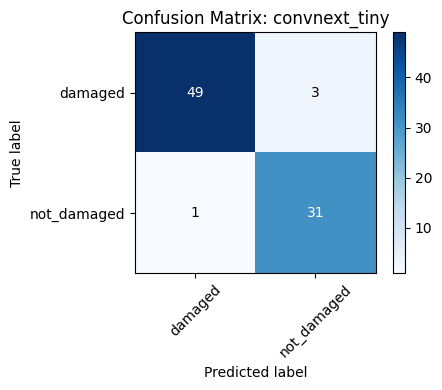

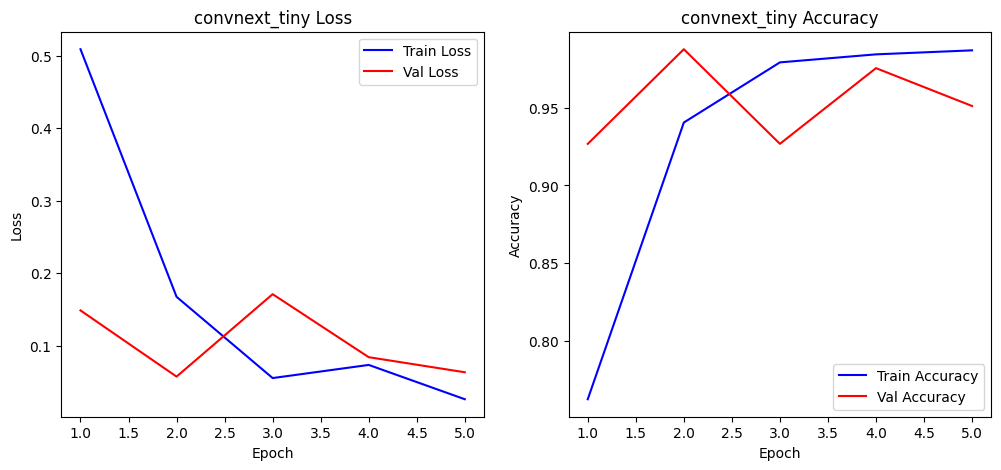


🚀 Training model: swin_tiny


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Epoch 1/5 - Train Loss: 0.2651, Train Acc: 0.8992 - Val Loss: 0.0824, Val Acc: 0.9634
Epoch 2/5 - Train Loss: 0.0623, Train Acc: 0.9767 - Val Loss: 0.0847, Val Acc: 0.9634
Epoch 3/5 - Train Loss: 0.1022, Train Acc: 0.9612 - Val Loss: 0.0412, Val Acc: 0.9878
Epoch 4/5 - Train Loss: 0.0272, Train Acc: 0.9922 - Val Loss: 0.0526, Val Acc: 0.9756
Epoch 5/5 - Train Loss: 0.0160, Train Acc: 0.9974 - Val Loss: 0.0362, Val Acc: 0.9878

🧪 Test results for swin_tiny
              precision    recall  f1-score   support

     damaged     0.9792    0.9038    0.9400        52
 not_damaged     0.8611    0.9688    0.9118        32

    accuracy                         0.9286        84
   macro avg     0.9201    0.9363    0.9259        84
weighted avg     0.9342    0.9286    0.9292        84



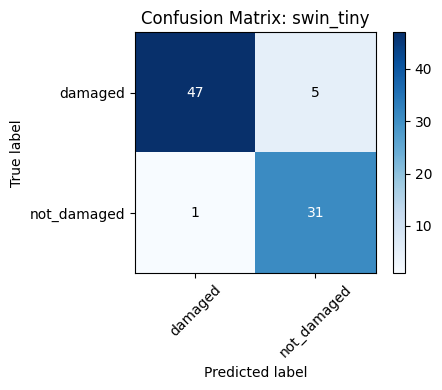

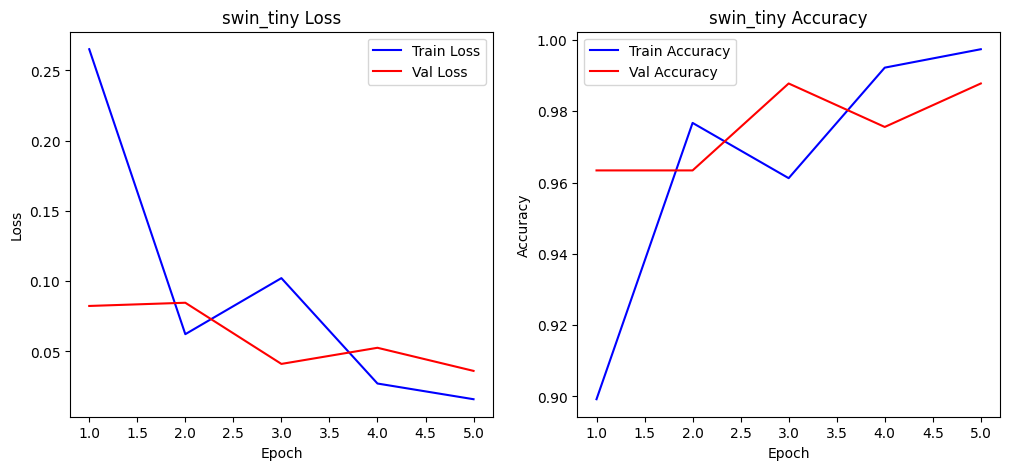

In [8]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import timm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import ImageOps
from torchvision.transforms import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Low-light simulation
class RandomDarken:
    def __init__(self, brightness_factor_range=(0.3, 1.0), p=0.5):
        self.brightness_factor_range = brightness_factor_range
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            factor = random.uniform(*self.brightness_factor_range)
            return F.adjust_brightness(img, factor)
        return img

# ✅ Histogram equalization
class HistogramEqualization:
    def __call__(self, img):
        return ImageOps.equalize(img)

# ✅ Updated transform pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    HistogramEqualization(),
    RandomDarken(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset paths
damaged_dir = "/kaggle/input/dataset/damaged-20250526T075728Z-1-001/damaged"
not_damaged_dir = "/kaggle/input/dataset/not-damaged-20250526T075830Z-1-001/not-damaged"

# Setup symlinked dataset directory
data_dir = "/kaggle/working/hazard_data"
os.makedirs(data_dir, exist_ok=True)

damaged_link = os.path.join(data_dir, "damaged")
not_damaged_link = os.path.join(data_dir, "not_damaged")

if not os.path.exists(damaged_link):
    os.symlink(damaged_dir, damaged_link)
if not os.path.exists(not_damaged_link):
    os.symlink(not_damaged_dir, not_damaged_link)

dataset = datasets.ImageFolder(data_dir, transform=transform)

# Dataset split
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

# ✅ Model loader
def get_model(name):
    if name == 'convnext_tiny':
        model = timm.create_model("convnext_tiny", pretrained=True, num_classes=2)
    elif name == 'swin_tiny':
        model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=2)
    else:
        raise ValueError(f"Unsupported model name: {name}")
    return model.to(device)

# ✅ Training function with best model saving
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=5, model_name=None):
    best_val_acc = 0.0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # ✅ Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"best_{model_name}.pth")

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return model, (train_losses, train_accs, val_losses, val_accs)

# ✅ Evaluation function
def evaluate_model(model, test_loader, device, model_name=None):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=dataset.classes, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.colorbar()
    tick_marks = np.arange(len(dataset.classes))
    plt.xticks(tick_marks, dataset.classes, rotation=45)
    plt.yticks(tick_marks, dataset.classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# ✅ Plotting
def plot_curves(train_losses, train_accs, val_losses, val_accs, model_name):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Val Loss')
    plt.title(f"{model_name} Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Val Accuracy')
    plt.title(f"{model_name} Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# ✅ Train and evaluate
models_to_run = ['convnext_tiny', 'swin_tiny']
for name in models_to_run:
    print(f"\n🚀 Training model: {name}")
    model = get_model(name)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    trained_model, curves = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=5, model_name=name)

    print(f"\n🧪 Test results for {name}")
    evaluate_model(trained_model, test_loader, device, model_name=name)

    plot_curves(*curves, model_name=name)


## convnext_tiny swin_tiny


🚀 Training model: convnext_tiny
Epoch 1/5 - Train Loss: 0.4471, Train Acc: 0.8269 - Val Loss: 0.3692, Val Acc: 0.9024
Epoch 2/5 - Train Loss: 0.1814, Train Acc: 0.9199 - Val Loss: 0.1088, Val Acc: 0.9756
Epoch 3/5 - Train Loss: 0.1145, Train Acc: 0.9432 - Val Loss: 0.1000, Val Acc: 0.9512
Epoch 4/5 - Train Loss: 0.0845, Train Acc: 0.9664 - Val Loss: 0.0801, Val Acc: 0.9878
Epoch 5/5 - Train Loss: 0.0170, Train Acc: 0.9974 - Val Loss: 0.0740, Val Acc: 0.9756

🧪 Test results for convnext_tiny
              precision    recall  f1-score   support

     damaged     0.9792    0.9038    0.9400        52
 not_damaged     0.8611    0.9688    0.9118        32

    accuracy                         0.9286        84
   macro avg     0.9201    0.9363    0.9259        84
weighted avg     0.9342    0.9286    0.9292        84



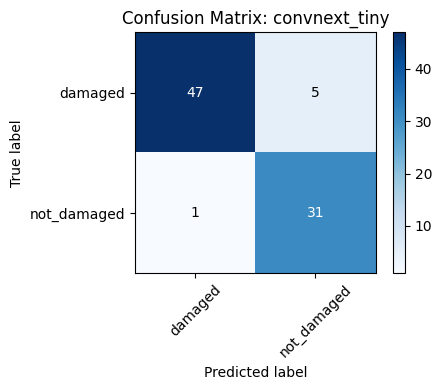

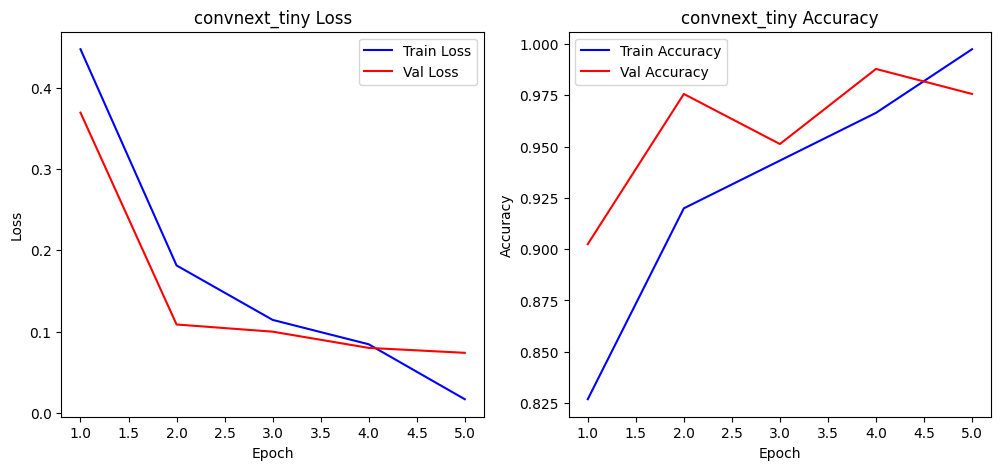


🚀 Training model: swin_tiny
Epoch 1/5 - Train Loss: 0.3117, Train Acc: 0.8501 - Val Loss: 0.1036, Val Acc: 0.9390
Epoch 2/5 - Train Loss: 0.1644, Train Acc: 0.9406 - Val Loss: 0.1093, Val Acc: 0.9512
Epoch 3/5 - Train Loss: 0.0611, Train Acc: 0.9767 - Val Loss: 0.0385, Val Acc: 1.0000
Epoch 4/5 - Train Loss: 0.0340, Train Acc: 0.9845 - Val Loss: 0.0254, Val Acc: 0.9878
Epoch 5/5 - Train Loss: 0.0164, Train Acc: 0.9897 - Val Loss: 0.0124, Val Acc: 1.0000

🧪 Test results for swin_tiny
              precision    recall  f1-score   support

     damaged     0.9792    0.9038    0.9400        52
 not_damaged     0.8611    0.9688    0.9118        32

    accuracy                         0.9286        84
   macro avg     0.9201    0.9363    0.9259        84
weighted avg     0.9342    0.9286    0.9292        84



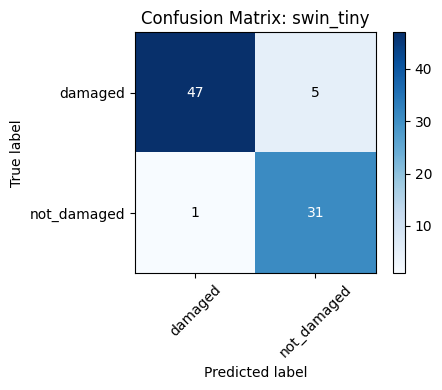

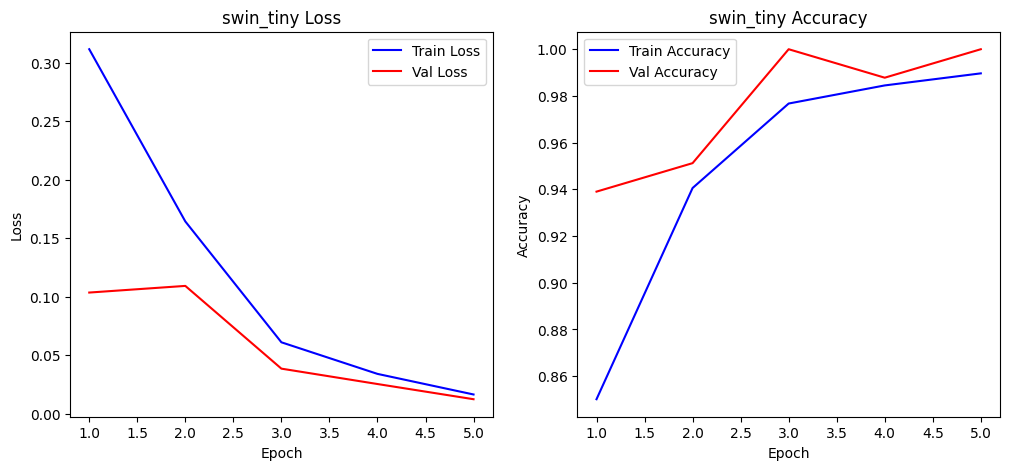

In [10]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import timm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import ImageOps
from torchvision.transforms import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Low-light simulation
class RandomDarken:
    def __init__(self, brightness_factor_range=(0.3, 1.0), p=0.5):
        self.brightness_factor_range = brightness_factor_range
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            factor = random.uniform(*self.brightness_factor_range)
            return F.adjust_brightness(img, factor)
        return img

# ✅ Histogram equalization
class HistogramEqualization:
    def __call__(self, img):
        return ImageOps.equalize(img)

# ✅ Updated transform pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    HistogramEqualization(),
    RandomDarken(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset paths
damaged_dir = "/kaggle/input/dataset/damaged-20250526T075728Z-1-001/damaged"
not_damaged_dir = "/kaggle/input/dataset/not-damaged-20250526T075830Z-1-001/not-damaged"

# Setup symlinked dataset directory
data_dir = "/kaggle/working/hazard_data"
os.makedirs(data_dir, exist_ok=True)

damaged_link = os.path.join(data_dir, "damaged")
not_damaged_link = os.path.join(data_dir, "not_damaged")

if not os.path.exists(damaged_link):
    os.symlink(damaged_dir, damaged_link)
if not os.path.exists(not_damaged_link):
    os.symlink(not_damaged_dir, not_damaged_link)

dataset = datasets.ImageFolder(data_dir, transform=transform)

# Dataset split
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

# ✅ Model loader
def get_model(name):
    if name == 'convnext_tiny':
        model = timm.create_model("convnext_tiny", pretrained=True, num_classes=2)
    elif name == 'swin_tiny':
        model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=2)
    else:
        raise ValueError(f"Unsupported model name: {name}")
    return model.to(device)

# ✅ Training function with best model saving
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=5, model_name=None):
    best_val_acc = 0.0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # ✅ Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"best_{model_name}.pth")

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return model, (train_losses, train_accs, val_losses, val_accs)

# ✅ Evaluation function
def evaluate_model(model, test_loader, device, model_name=None):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=dataset.classes, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.colorbar()
    tick_marks = np.arange(len(dataset.classes))
    plt.xticks(tick_marks, dataset.classes, rotation=45)
    plt.yticks(tick_marks, dataset.classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# ✅ Plotting
def plot_curves(train_losses, train_accs, val_losses, val_accs, model_name):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Val Loss')
    plt.title(f"{model_name} Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Val Accuracy')
    plt.title(f"{model_name} Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# ✅ Train and evaluate
models_to_run = ['convnext_tiny', 'swin_tiny']
for name in models_to_run:
    print(f"\n🚀 Training model: {name}")
    model = get_model(name)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    trained_model, curves = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=5, model_name=name)

    print(f"\n🧪 Test results for {name}")
    evaluate_model(trained_model, test_loader, device, model_name=name)

    plot_curves(*curves, model_name=name)


## Inception v3 

Epoch 1/5 - Train Loss: 0.5779, Acc: 0.8165 - Val Loss: 0.2984, Acc: 0.8659
Epoch 2/5 - Train Loss: 0.2025, Acc: 0.9612 - Val Loss: 0.1915, Acc: 0.9512
Epoch 3/5 - Train Loss: 0.1270, Acc: 0.9742 - Val Loss: 0.1427, Acc: 0.9512
Epoch 4/5 - Train Loss: 0.1088, Acc: 0.9716 - Val Loss: 0.1177, Acc: 0.9390
Epoch 5/5 - Train Loss: 0.0898, Acc: 0.9793 - Val Loss: 0.0886, Acc: 0.9756

🧪 Test Results
              precision    recall  f1-score   support

     damaged     0.9787    0.8846    0.9293        52
 not_damaged     0.8378    0.9688    0.8986        32

    accuracy                         0.9167        84
   macro avg     0.9083    0.9267    0.9139        84
weighted avg     0.9251    0.9167    0.9176        84



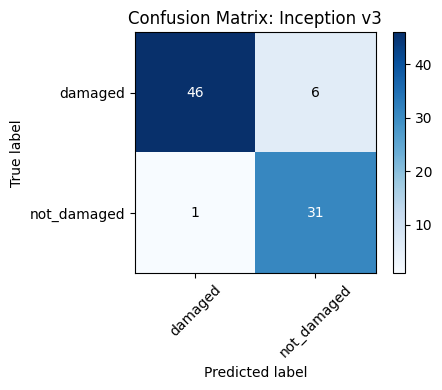

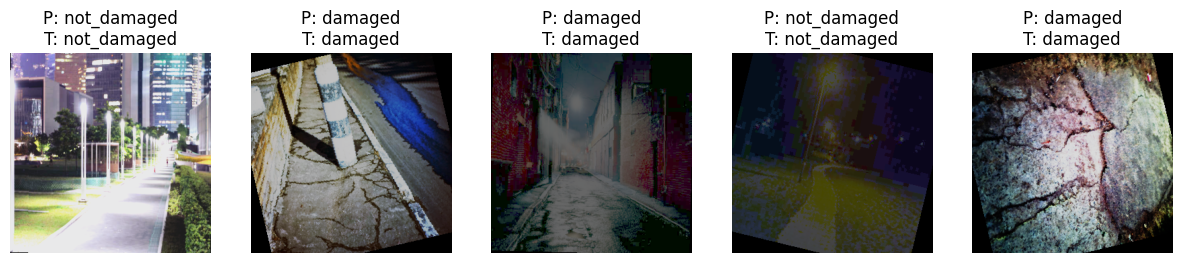

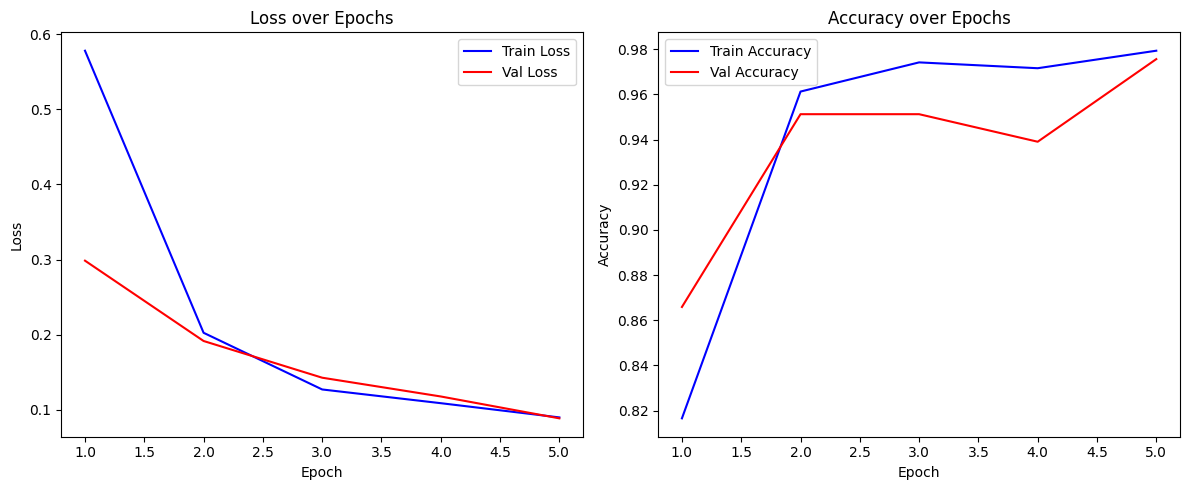

In [12]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import functional as F
from PIL import ImageOps
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Custom low-light (darken) transform
class RandomDarken:
    def __init__(self, brightness_factor_range=(0.3, 1.0), p=0.5):
        self.brightness_factor_range = brightness_factor_range
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            factor = random.uniform(*self.brightness_factor_range)
            return F.adjust_brightness(img, factor)
        return img

# ✅ Histogram Equalization transform
class HistogramEqualization:
    def __call__(self, img):
        return ImageOps.equalize(img)

# ✅ Transform pipeline
transform = transforms.Compose([
    transforms.RandomResizedCrop(299, scale=(0.8, 1.0)),  # zoom
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    HistogramEqualization(),
    RandomDarken((0.3, 1.0), p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset paths
damaged_dir = "/kaggle/input/dataset/damaged-20250526T075728Z-1-001/damaged"
not_damaged_dir = "/kaggle/input/dataset/not-damaged-20250526T075830Z-1-001/not-damaged"

# Dataset symlink setup
data_dir = "/kaggle/working/hazard_data"
os.makedirs(data_dir, exist_ok=True)

damaged_link = os.path.join(data_dir, "damaged")
not_damaged_link = os.path.join(data_dir, "not_damaged")

if not os.path.exists(damaged_link):
    os.symlink(damaged_dir, damaged_link)
if not os.path.exists(not_damaged_link):
    os.symlink(not_damaged_dir, not_damaged_link)

dataset = datasets.ImageFolder(data_dir, transform=transform)

# Train/val/test split
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size],
                                               generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

# Inception v3 model setup
model = models.inception_v3(pretrained=True, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, 2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ✅ Training function with best model saving
def train_inception(model, train_loader, val_loader, criterion, optimizer, device, epochs=5):
    best_val_acc = 0.0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, aux_outputs = model(images)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # ✅ Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_inceptionv3.pth")

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    return model, (train_losses, train_accs, val_losses, val_accs)

# ✅ Evaluation with confusion matrix + sample predictions
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels, sample_images = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            if len(sample_images) < 5:
                sample_images.extend([(img.cpu(), pred.item(), label.item())
                                      for img, pred, label in zip(images, preds, labels)])

    print(classification_report(all_labels, all_preds, target_names=dataset.classes, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix: Inception v3')
    plt.colorbar()
    tick_marks = np.arange(len(dataset.classes))
    plt.xticks(tick_marks, dataset.classes, rotation=45)
    plt.yticks(tick_marks, dataset.classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    # ✅ Show sample predictions
    class_names = dataset.classes
    plt.figure(figsize=(15, 3))
    for i, (img, pred, label) in enumerate(sample_images[:5]):
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) +
                      np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f"P: {class_names[pred]}\nT: {class_names[label]}")
        plt.axis("off")
    plt.show()

# ✅ Plotting loss & accuracy
def plot_curves(train_losses, train_accs, val_losses, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Val Loss')
    plt.title("Loss over Epochs")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Val Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# ✅ Train and evaluate
trained_model, curves = train_inception(model, train_loader, val_loader, criterion, optimizer, device, epochs=5)

print("\n🧪 Test Results")
evaluate_model(trained_model, test_loader, device)

plot_curves(*curves)
